# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Train set: filter none.
Valid set: filter middle.

In [24]:
from datetime import datetime
print(datetime.now())

2023-04-01 21:39:51.413172


In [25]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [26]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = True
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = True

Python 3.9.16
sklearn 1.2.2


In [27]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [28]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [29]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [30]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [31]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-01 21:39:52.578307
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_64 (Dense)            (None, 64)                65664     
                                                                 
 dense_65 (Dense)            (None, 64)                4160      
                                                                 
 dense_66 (Dense)            (None, 64)                4160      
                                                                 
 dense_67 (Dense)            (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [32]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [33]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-01 21:39:52.731724
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-04-01 21:40:11.760889

Training # 1 1
2023-04-01 21:40:11.761692
2023-04-01 21:40:11.761748
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 280:262 51.66%
FIT
2023-04-01 21:40:11.824724


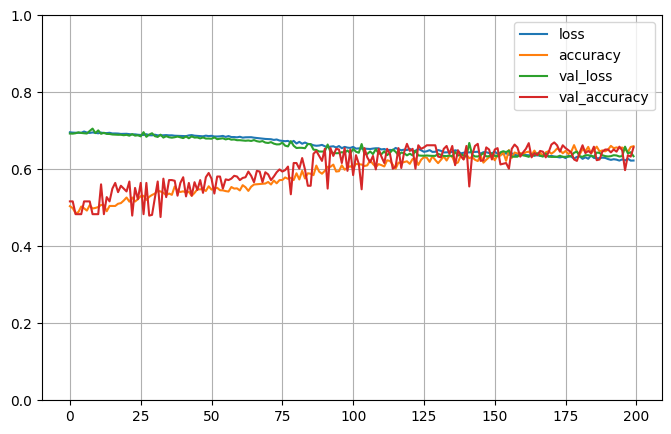


2023-04-01 21:41:34.754693

Testing # 1 1
2023-04-01 21:41:34.754833
2023-04-01 21:41:34.754886
PREDICT
2023-04-01 21:41:34.761762
Test 1:0 280:262 51.66%
Predict 1:0 326:216 60.15%
Test sizes (542, 1025) (542,)
Range of scores: 0.011151204 to 0.94800866
Score threshold 0.5
Confusion matrix
 [[146 116]
 [ 70 210]]
Normalized matrix
 [[0.26937269 0.21402214]
 [0.12915129 0.38745387]]


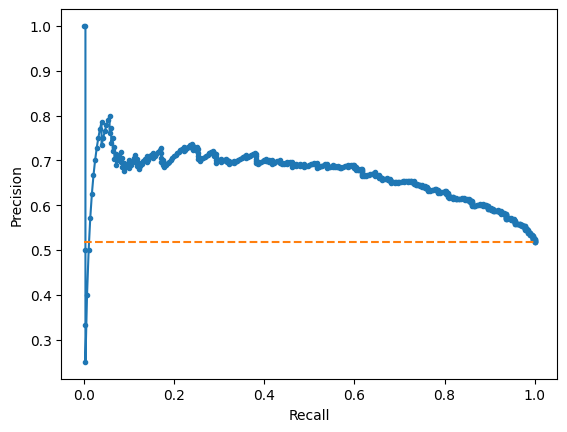

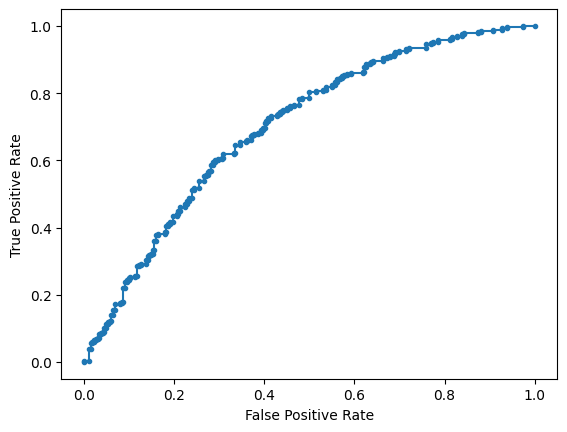

Accuracy: 65.68% Precision: 64.42% Recall: 75.00%
F1: 69.31% MCC: 0.3136
AUPRC: 66.82% AUROC: 69.96%
 accuracy [65.68265682656826]
 precision [64.41717791411043]
 recall [75.0]
 F1 [69.30693069306932]
 MCC [0.3136090412525251]
 AUPRC [66.8175130026697]
 AUROC [69.96455834242093]
2023-04-01 21:41:35.268841

Training # 1 2
2023-04-01 21:41:35.271203
2023-04-01 21:41:35.271280
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 249:263 48.63%
FIT
2023-04-01 21:41:35.340198


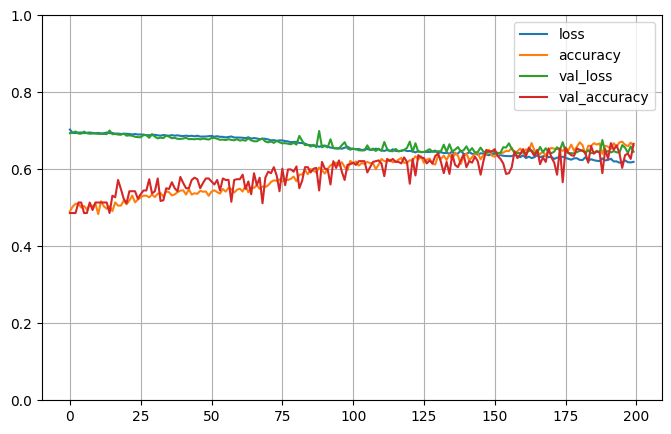


2023-04-01 21:42:58.283312

Testing # 1 2
2023-04-01 21:42:58.285477
2023-04-01 21:42:58.285511
PREDICT
2023-04-01 21:42:58.300044
Test 1:0 249:263 48.63%
Predict 1:0 312:200 60.94%
Test sizes (512, 1025) (512,)
Range of scores: 0.0097918445 to 0.98221105
Score threshold 0.5
Confusion matrix
 [[146 117]
 [ 54 195]]
Normalized matrix
 [[0.28515625 0.22851562]
 [0.10546875 0.38085938]]


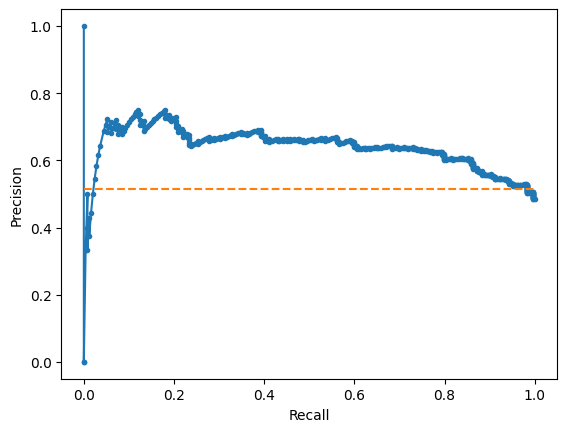

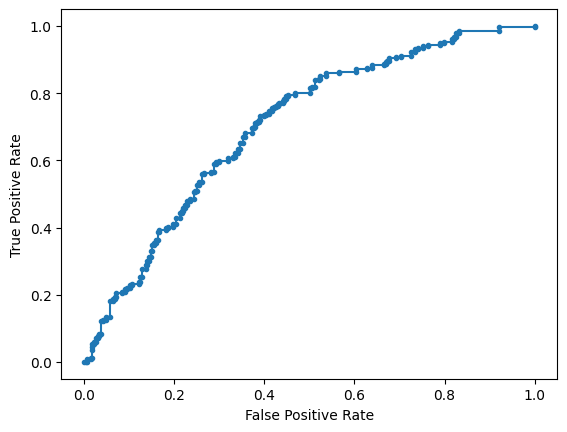

Accuracy: 66.60% Precision: 62.50% Recall: 78.31%
F1: 69.52% MCC: 0.3465
AUPRC: 63.88% AUROC: 70.29%
 accuracy [66.6015625]
 precision [62.5]
 recall [78.3132530120482]
 F1 [69.5187165775401]
 MCC [0.34653180451262866]
 AUPRC [63.87882201842149]
 AUROC [70.29334066303235]
2023-04-01 21:42:58.794345

Training # 1 3
2023-04-01 21:42:58.795546
2023-04-01 21:42:58.795625
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 257:259 49.81%
FIT
2023-04-01 21:42:58.861763


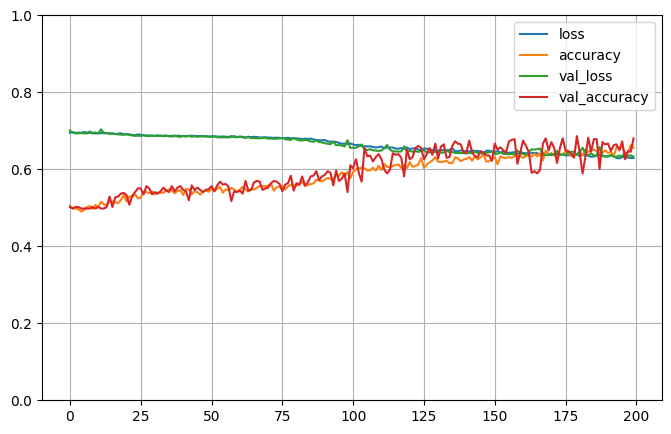


2023-04-01 21:44:21.712881

Testing # 1 3
2023-04-01 21:44:21.713185
2023-04-01 21:44:21.713227
PREDICT
2023-04-01 21:44:21.722210
Test 1:0 257:259 49.81%
Predict 1:0 232:284 44.96%
Test sizes (516, 1025) (516,)
Range of scores: 0.035568617 to 0.95110554
Score threshold 0.5
Confusion matrix
 [[189  70]
 [ 95 162]]
Normalized matrix
 [[0.36627907 0.13565891]
 [0.18410853 0.31395349]]


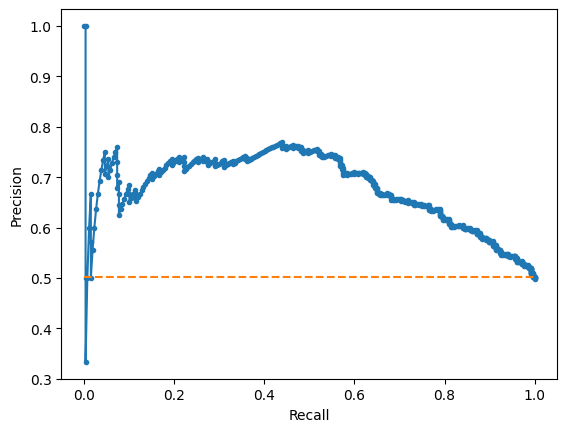

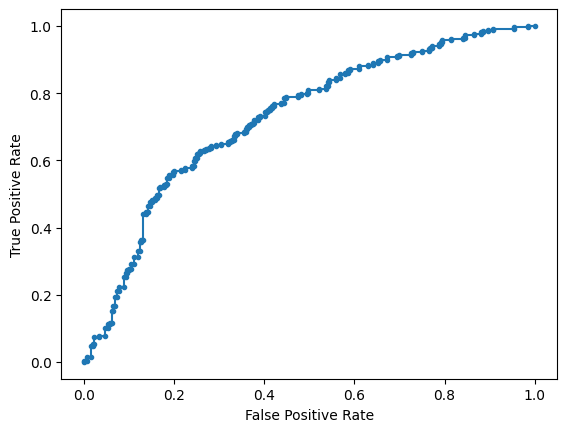

Accuracy: 68.02% Precision: 69.83% Recall: 63.04%
F1: 66.26% MCC: 0.3619
AUPRC: 67.89% AUROC: 72.57%
 accuracy [68.02325581395348]
 precision [69.82758620689656]
 recall [63.035019455252915]
 F1 [66.25766871165645]
 MCC [0.3619196721586047]
 AUPRC [67.88500853177875]
 AUROC [72.56583988101498]
2023-04-01 21:44:22.227104

Training # 1 4
2023-04-01 21:44:22.231945
2023-04-01 21:44:22.231985
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 268:252 51.54%
FIT
2023-04-01 21:44:22.299361


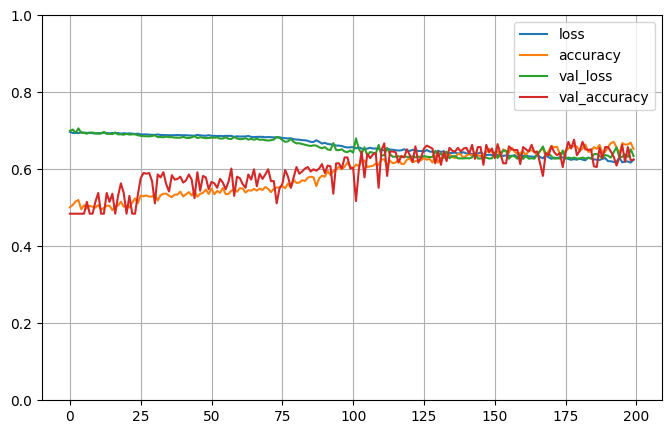


2023-04-01 21:45:21.987864

Testing # 1 4
2023-04-01 21:45:21.987925
2023-04-01 21:45:21.987954
PREDICT
2023-04-01 21:45:21.991459
Test 1:0 268:252 51.54%
Predict 1:0 361:159 69.42%
Test sizes (520, 1025) (520,)
Range of scores: 0.011842497 to 0.9664544
Score threshold 0.5
Confusion matrix
 [[108 144]
 [ 51 217]]
Normalized matrix
 [[0.20769231 0.27692308]
 [0.09807692 0.41730769]]


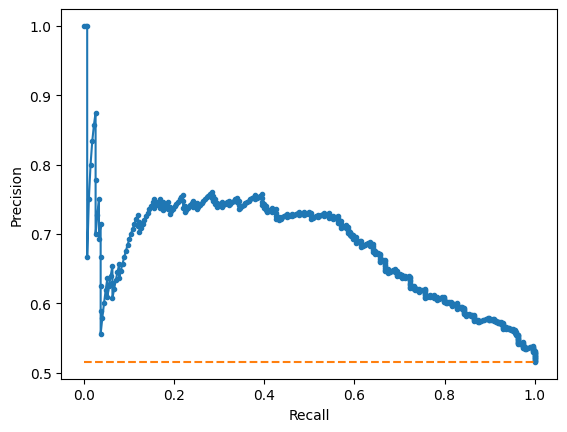

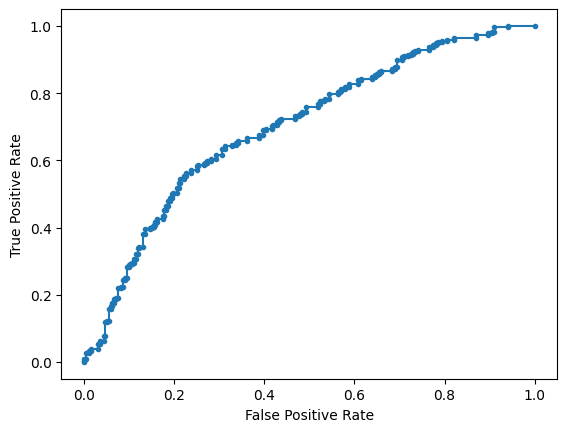

Accuracy: 62.50% Precision: 60.11% Recall: 80.97%
F1: 69.00% MCC: 0.2585
AUPRC: 68.03% AUROC: 70.07%
 accuracy [62.5]
 precision [60.11080332409973]
 recall [80.97014925373134]
 F1 [68.99841017488076]
 MCC [0.2584581273780359]
 AUPRC [68.03080081439887]
 AUROC [70.06633499170813]
2023-04-01 21:45:22.654102

Training # 1 5
2023-04-01 21:45:22.655890
2023-04-01 21:45:22.656193
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 269:257 51.14%
FIT
2023-04-01 21:45:22.752320


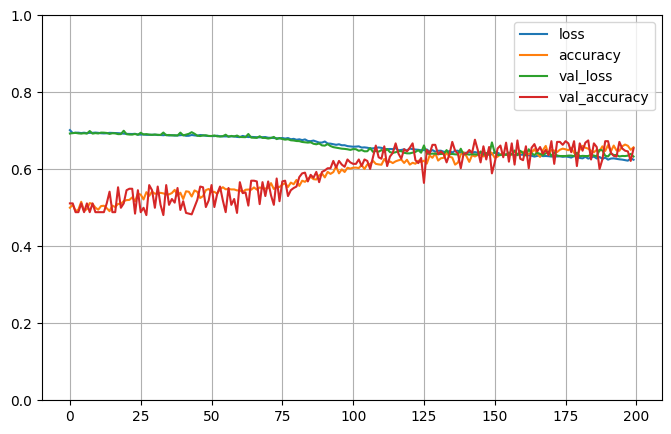


2023-04-01 21:46:24.944380

Testing # 1 5
2023-04-01 21:46:24.944830
2023-04-01 21:46:24.944861
PREDICT
2023-04-01 21:46:24.948453
Test 1:0 269:257 51.14%
Predict 1:0 309:217 58.75%
Test sizes (526, 1025) (526,)
Range of scores: 0.015095935 to 0.97670484
Score threshold 0.5
Confusion matrix
 [[146 111]
 [ 71 198]]
Normalized matrix
 [[0.27756654 0.21102662]
 [0.13498099 0.37642586]]


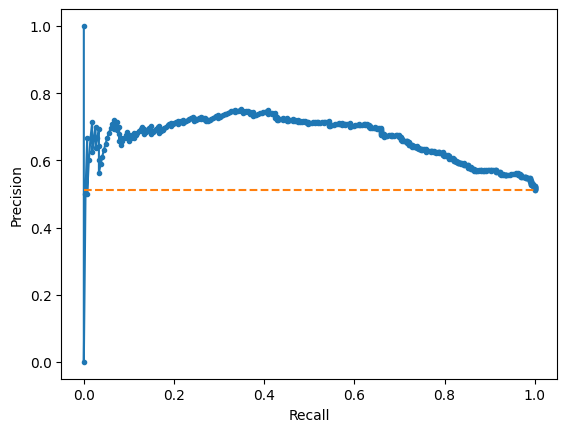

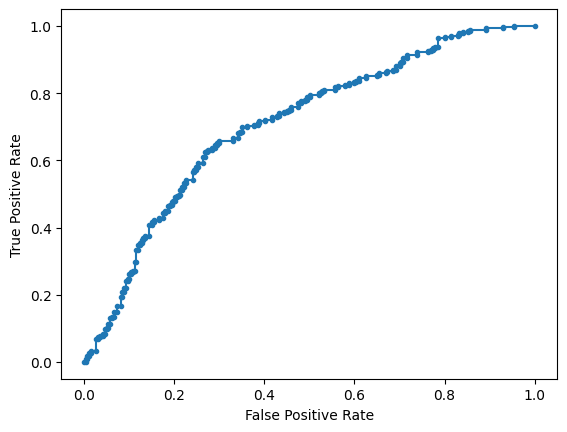

Accuracy: 65.40% Precision: 64.08% Recall: 73.61%
F1: 68.51% MCC: 0.3088
AUPRC: 66.97% AUROC: 70.74%
 accuracy [65.39923954372624]
 precision [64.07766990291263]
 recall [73.60594795539033]
 F1 [68.5121107266436]
 MCC [0.30883428442584804]
 AUPRC [66.96658309194503]
 AUROC [70.73611733904214]
2023-04-01 21:46:25.454816

Training # 2 1
2023-04-01 21:46:25.459779
2023-04-01 21:46:25.460352
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 274:258 51.50%
FIT
2023-04-01 21:46:25.530690


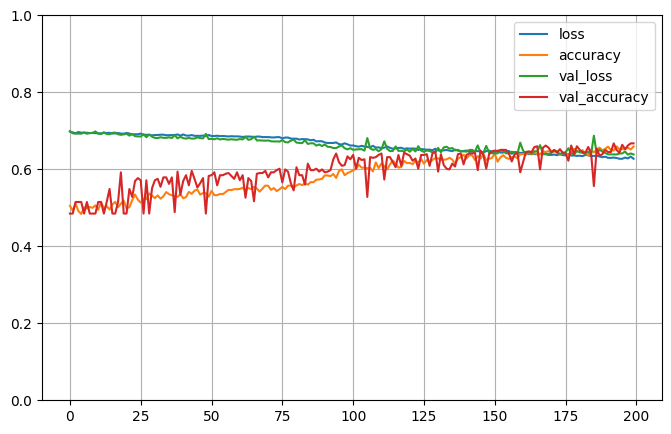


2023-04-01 21:47:25.444131

Testing # 2 1
2023-04-01 21:47:25.445788
2023-04-01 21:47:25.446178
PREDICT
2023-04-01 21:47:25.450505
Test 1:0 274:258 51.50%
Predict 1:0 325:207 61.09%
Test sizes (532, 1025) (532,)
Range of scores: 0.03759333 to 0.9866232
Score threshold 0.5
Confusion matrix
 [[144 114]
 [ 63 211]]
Normalized matrix
 [[0.27067669 0.21428571]
 [0.11842105 0.39661654]]


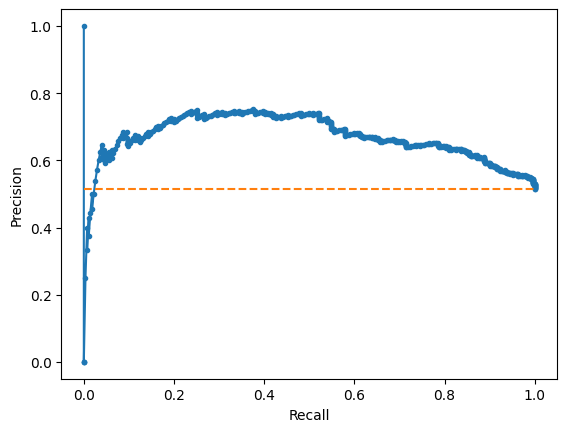

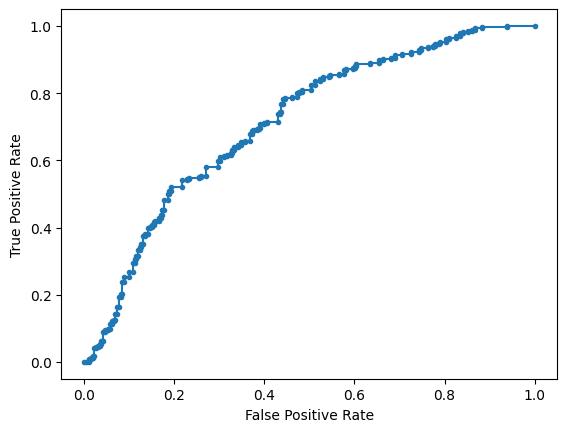

Accuracy: 66.73% Precision: 64.92% Recall: 77.01%
F1: 70.45% MCC: 0.3364
AUPRC: 66.67% AUROC: 71.26%
 accuracy [66.72932330827066]
 precision [64.92307692307693]
 recall [77.00729927007299]
 F1 [70.4507512520868]
 MCC [0.336444501351999]
 AUPRC [66.66984554296076]
 AUROC [71.26407514287331]
2023-04-01 21:47:25.920730

Training # 2 2
2023-04-01 21:47:25.921965
2023-04-01 21:47:25.922194
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 261:263 49.81%
FIT
2023-04-01 21:47:25.983276


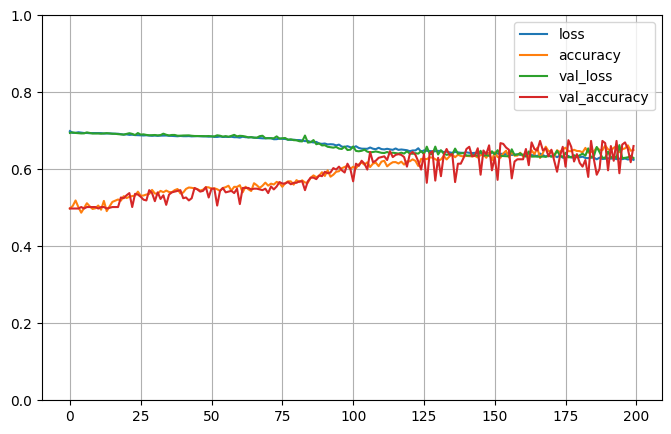


2023-04-01 21:48:26.768142

Testing # 2 2
2023-04-01 21:48:26.768636
2023-04-01 21:48:26.768668
PREDICT
2023-04-01 21:48:26.775714
Test 1:0 261:263 49.81%
Predict 1:0 297:227 56.68%
Test sizes (524, 1025) (524,)
Range of scores: 0.02231978 to 0.96027774
Score threshold 0.5
Confusion matrix
 [[156 107]
 [ 71 190]]
Normalized matrix
 [[0.29770992 0.20419847]
 [0.13549618 0.36259542]]


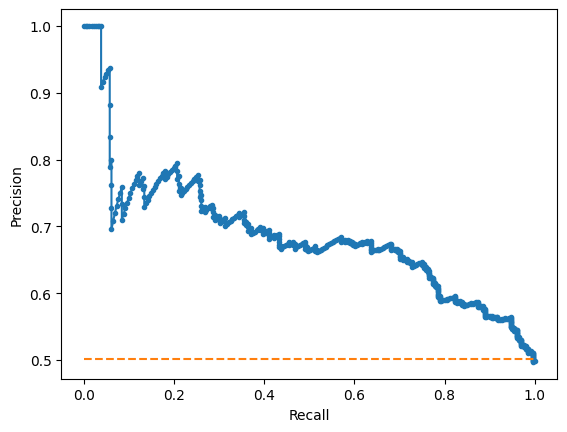

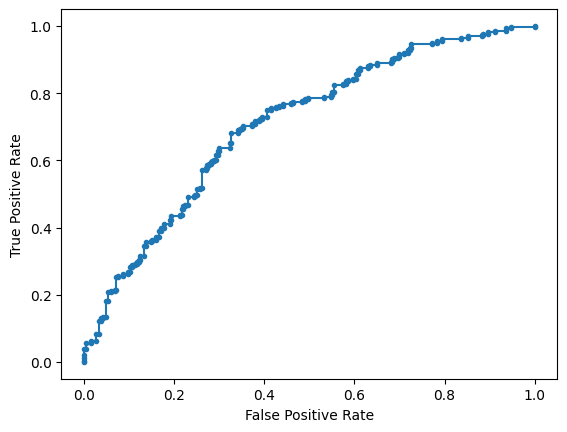

Accuracy: 66.03% Precision: 63.97% Recall: 72.80%
F1: 68.10% MCC: 0.3240
AUPRC: 68.67% AUROC: 70.74%
 accuracy [66.03053435114504]
 precision [63.97306397306397]
 recall [72.79693486590038]
 F1 [68.10035842293907]
 MCC [0.32402716382568236]
 AUPRC [68.6704892039918]
 AUROC [70.7428288390659]
2023-04-01 21:48:27.248561

Training # 2 3
2023-04-01 21:48:27.250459
2023-04-01 21:48:27.250847
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 276:242 53.28%
FIT
2023-04-01 21:48:27.309350


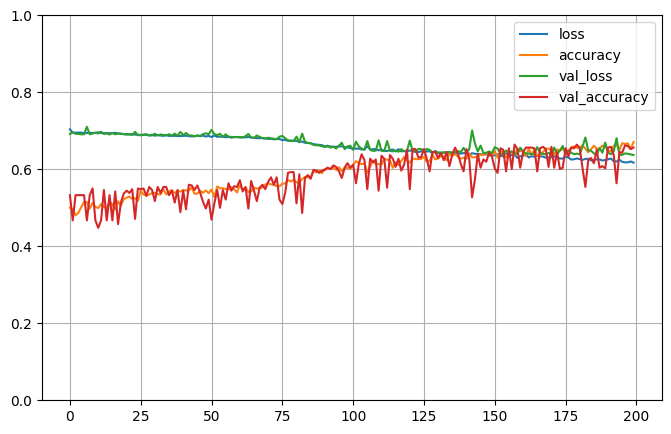


2023-04-01 21:49:50.217103

Testing # 2 3
2023-04-01 21:49:50.218666
2023-04-01 21:49:50.219057
PREDICT
2023-04-01 21:49:50.223523
Test 1:0 276:242 53.28%
Predict 1:0 330:188 63.71%
Test sizes (518, 1025) (518,)
Range of scores: 0.0056995098 to 0.9512664
Score threshold 0.5
Confusion matrix
 [[126 116]
 [ 62 214]]
Normalized matrix
 [[0.24324324 0.22393822]
 [0.11969112 0.41312741]]


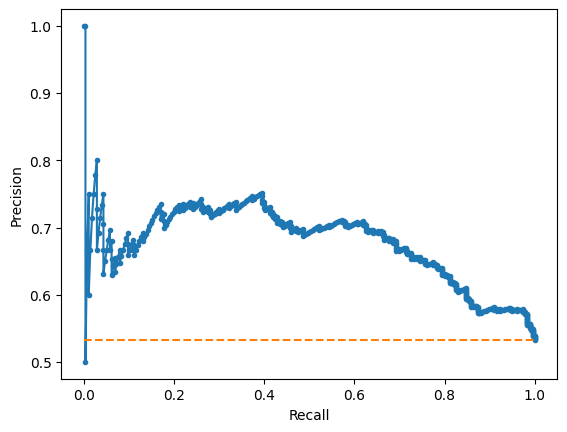

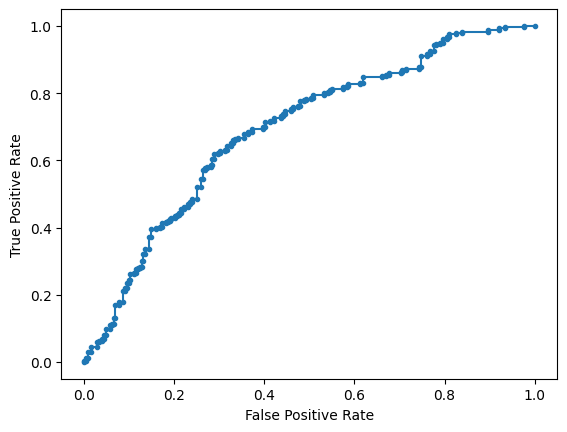

Accuracy: 65.64% Precision: 64.85% Recall: 77.54%
F1: 70.63% MCC: 0.3072
AUPRC: 67.77% AUROC: 69.13%
 accuracy [65.63706563706563]
 precision [64.84848484848484]
 recall [77.53623188405797]
 F1 [70.62706270627064]
 MCC [0.30715138869490854]
 AUPRC [67.77379380409509]
 AUROC [69.1265421008504]
2023-04-01 21:49:50.687937

Training # 2 4
2023-04-01 21:49:50.689477
2023-04-01 21:49:50.689790
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 255:269 48.66%
FIT
2023-04-01 21:49:50.755442


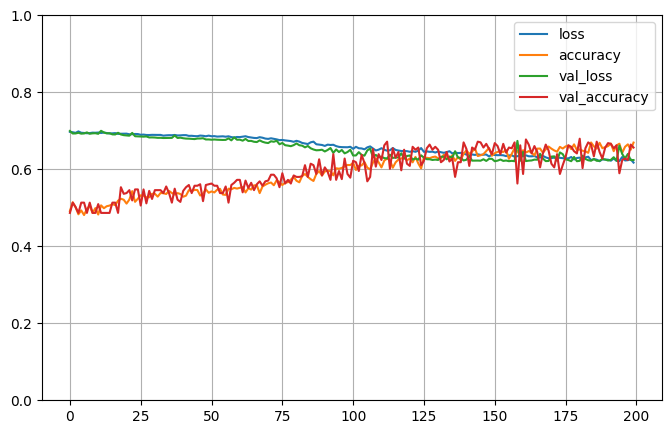


2023-04-01 21:50:51.468639

Testing # 2 4
2023-04-01 21:50:51.469082
2023-04-01 21:50:51.469114
PREDICT
2023-04-01 21:50:51.472510
Test 1:0 255:269 48.66%
Predict 1:0 239:285 45.61%
Test sizes (524, 1025) (524,)
Range of scores: 0.005351699 to 0.8876646
Score threshold 0.5
Confusion matrix
 [[187  82]
 [ 98 157]]
Normalized matrix
 [[0.35687023 0.15648855]
 [0.1870229  0.29961832]]


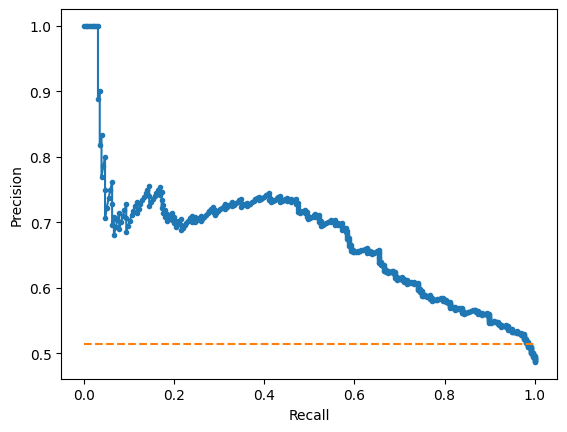

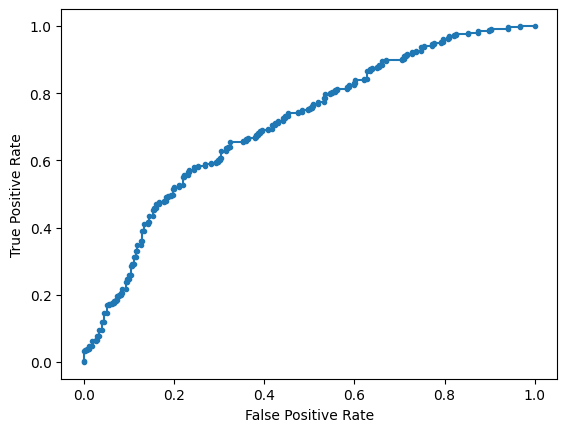

Accuracy: 65.65% Precision: 65.69% Recall: 61.57%
F1: 63.56% MCC: 0.3119
AUPRC: 67.41% AUROC: 70.75%
 accuracy [65.64885496183206]
 precision [65.69037656903765]
 recall [61.568627450980394]
 F1 [63.562753036437236]
 MCC [0.31194691585024764]
 AUPRC [67.41125099402976]
 AUROC [70.7471390043006]
2023-04-01 21:50:52.004262

Training # 2 5
2023-04-01 21:50:52.005207
2023-04-01 21:50:52.005263
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 257:261 49.61%
FIT
2023-04-01 21:50:52.066487


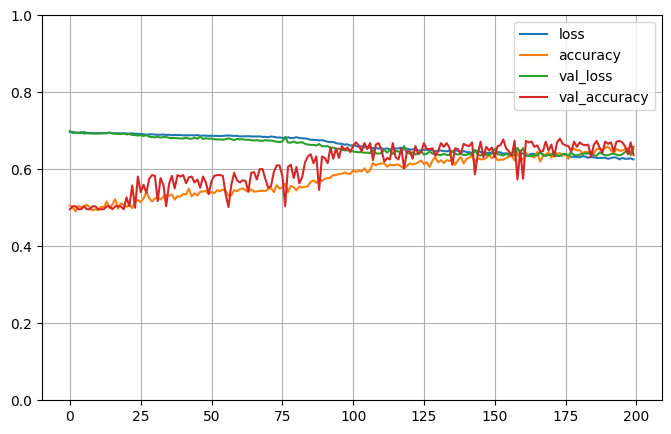


2023-04-01 21:52:15.063629

Testing # 2 5
2023-04-01 21:52:15.064919
2023-04-01 21:52:15.065209
PREDICT
2023-04-01 21:52:15.071145
Test 1:0 257:261 49.61%
Predict 1:0 401:117 77.41%
Test sizes (518, 1025) (518,)
Range of scores: 0.030066272 to 0.9806131
Score threshold 0.5
Confusion matrix
 [[ 95 166]
 [ 22 235]]
Normalized matrix
 [[0.18339768 0.32046332]
 [0.04247104 0.45366795]]


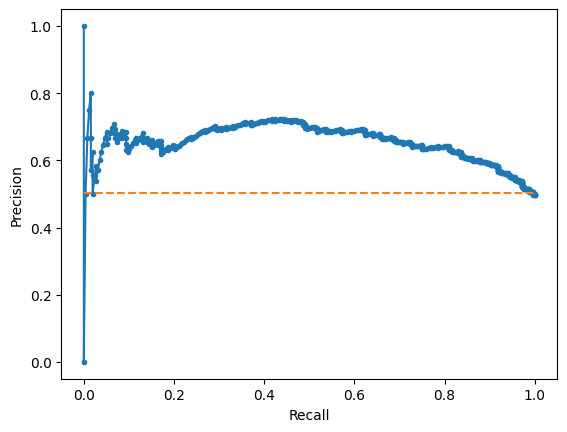

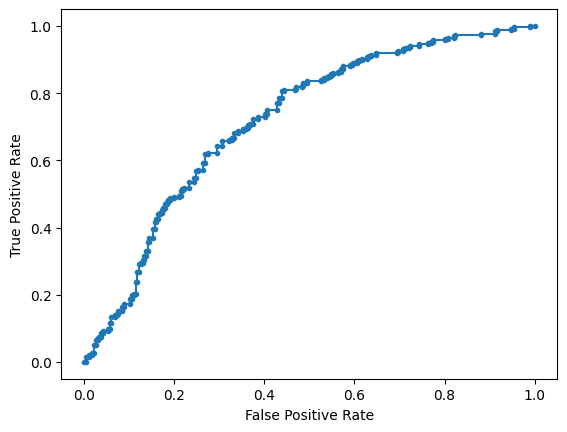

Accuracy: 63.71% Precision: 58.60% Recall: 91.44%
F1: 71.43% MCC: 0.3329
AUPRC: 65.40% AUROC: 71.75%
 accuracy [63.7065637065637]
 precision [58.60349127182045]
 recall [91.43968871595331]
 F1 [71.42857142857143]
 MCC [0.33286042602163446]
 AUPRC [65.40033341776808]
 AUROC [71.75335808101137]
2023-04-01 21:52:15.669188


In [34]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [35]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 65.60% std 1.55
 precision mean 63.90% std 3.07
 recall mean 75.13% std 8.55
 F1 mean 68.68% std 2.31
 MCC mean 0.32% std 0.03
 AUPRC mean 66.95% std 1.41
 AUROC mean 70.73% std 0.97
 accuracy [[65.68265682656826], [66.6015625], [68.02325581395348], [62.5], [65.39923954372624], [66.72932330827066], [66.03053435114504], [65.63706563706563], [65.64885496183206], [63.7065637065637]]
 precision [[64.41717791411043], [62.5], [69.82758620689656], [60.11080332409973], [64.07766990291263], [64.92307692307693], [63.97306397306397], [64.84848484848484], [65.69037656903765], [58.60349127182045]]
 recall [[75.0], [78.3132530120482], [63.035019455252915], [80.97014925373134], [73.60594795539033], [77.00729927007299], [72.79693486590038], [77.53623188405797], [61.568627450980394], [91.43968871595331]]
 F1 [[69.30693069306932], [69.5187165775401], [66.25766871165645], [68.99841017488076], [68.5121107266436], [70.4507512520868], [68.10035842293907], [70.62706270627064], [63.562753036437